# 길찾기 알고리즘 속도 및 성능 비교

osmnx, taxicab, osrm 의 속도 및 성능 비교

In [155]:
import pandas as pd
import folium
import osmnx as ox
from numpy import random
from shapely.geometry import Point
import warnings 

warnings.filterwarnings("ignore")

In [10]:
G = ox.graph_from_place("서울특별시, 대한민국", network_type="drive_service", simplify=True)

In [3]:
nodes, edges = ox.graph_to_gdfs(G)

In [6]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [261]:
orig = (37.52662, 127.00079)
dest = (37.52794, 127.12386)

In [36]:
# 출발지 목적지를 인접 Node에 붙임 (오차가 발생할 수 밖에 없으나 이거 안하면 Error가 남)
orig_n = ox.distance.nearest_nodes(G, X=orig[1],Y=orig[0])
dest_n = ox.distance.nearest_nodes(G, X=dest[1] , Y=dest[0])

# 통행시간 기준 경로 계산
route = ox.shortest_path(G, orig_n, dest_n, weight="travel_time")

In [46]:
%%timeit
orig_n = ox.distance.nearest_nodes(G, X=orig[1],Y=orig[0])
dest_n = ox.distance.nearest_nodes(G, X=dest[1] , Y=dest[0])
route = ox.shortest_path(G, orig_n, dest_n, weight="travel_time")

393 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


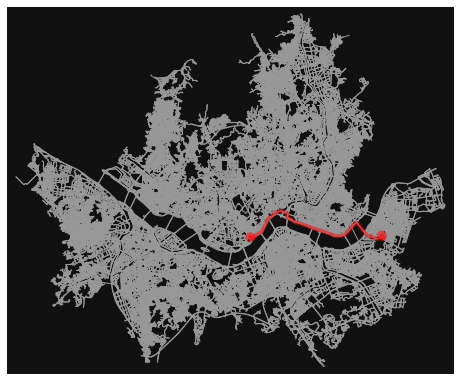

In [26]:
# 시각화
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [12]:
# Taxicab에 있는 함수로 계산, 인접노드에 붙이는 것 없이 바로 가능
# 시간이 더 오래걸린다는 단점
# Weight 값도 Travel time으로 줄 수 없음
route2 = tc.distance.shortest_path(G,orig,dest)

C:\Users\user\anaconda3\envs\pydeck\lib\site-packages\osmnx\distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
C:\Users\user\anaconda3\envs\pydeck\lib\site-packages\osmnx\distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))


### OSRM

import polyline
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [28]:
import polyline
import folium
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [29]:
session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

In [170]:
# 출발지와 목적지 경도(x,lon), 위도(y,lat)가 주어졌을 때 통행시간을 뽑는 함수
# Dispatch Algorithm을 작동할 때 사용
# 경로를 알 필요가 없고 통행시간만 뽑을 때 사용

def get_travel_time(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat):
    loc = "{},{};{},{}".format(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat)
    url = "http://127.0.0.1:5000/route/v1/driving/"
    r = session.get(url + loc)#+steps) 
    if r.status_code!= 200:
        return {}
  
    res = r.json()   
    duration = res['routes'][0]['duration']

    return duration

In [87]:
def get_route(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat):
    
    #steps = "?steps=true"
    loc = "{},{};{},{}".format(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat)
    url = "http://127.0.0.1:5000/route/v1/driving/"
    r = session.get(url + loc)#+steps) 
    if r.status_code!= 200:
        return {}
  
    res = r.json()   
    routes = polyline.decode(res['routes'][0]['geometry'])
    distance = res['routes'][0]['distance']
    duration = res['routes'][0]['duration']
    
    out = routes
    
    # out = {'route':routes,
    #        'start_point':start_point,
    #        'end_point':end_point,
    #        'distance':distance,
    #        'duration': duration
    #       }

    return (out,distance,duration)

In [278]:
len(polyline.decode("iu_dFwtffW}AmBwAqBoAmBiD_FoDmFgA_BsAkBaAoAoAmAwAyAeGmDyEeDeDmByCaCgA{@aAaA}@aAw@eAe@cAe@mAa@eB]kBW}CGeBCaBPkD`@cCP}@t@wDhBsIn@{DfAqGtAmJz@qGlAiIb@iCbF_V^cB~BqNpCoRn@{EZsAf@wAR_@R_@^k@DIn@aAbA_Az@u@VQhAuAz@aAv@eAx@qA|@wA`AiBnAeCl@qAhFkLn@cAp@m@z@k@z@e@^SlAk@b@Wf@i@fAsAjA_B`DqEt@gA`@s@Te@Rs@Pu@Jo@Fi@@k@DeBLgGNaHF}@B}@AaAI}AG}AAoAF}Ad@_EP}BRcB~@}Gv@yIj@aFPoBLgBJ{BHaDFsB@sBAkEMqEM}EC{@i@yJ[gEUsB_@aCa@mB{@oD]}AsBeJs@sCm@wB_@iAyAcDaCgF_CaF{@gBmBcEa@}@yGaMaEyFuKmM"))

126

In [ ]:
# 상세한 경로와 시간을 뽑는 함수
# 시간이 많이 걸리기 때문에 최종적으로 시각화 할 때만 사용

def get_route_and_time(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat):
    
    steps = "?steps=true"
    loc = "{},{};{},{}".format(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat)
    url = "http://127.0.0.1:5000/route/v1/driving/"
    r = session.get(url + loc + steps) 
    if r.status_code!= 200:
        return {}
  
    res = r.json()   
    routes = polyline.decode(res['routes'][0]['geometry'])
    distance = res['routes'][0]['distance']
    duration = res['routes'][0]['duration']
    
    out = routes
    
    return (out,distance,duration)

In [262]:
pickup_lon = orig[1]
pickup_lat = orig[0]
dropoff_lon = dest[1]
dropoff_lat = dest[0]

In [253]:
steps = "?steps=true"
loc = "{},{};{},{}".format(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat)
url = "http://127.0.0.1:5000/route/v1/driving/"
r = session.get(url + loc + steps) 
res = r.json()  

In [276]:
import json
with open('data.json', 'w') as fp:
    json.dump(res, fp,  indent=4)


In [257]:
steps = res['routes'][0]['legs'][0]['steps']

In [131]:
steps[0]['geometry']

'kl`dF}ycfWV`@'

In [270]:
polyline.decode(steps[10]['geometry'])

[(37.52641, 127.10611),
 (37.5276, 127.10767),
 (37.52793, 127.10809),
 (37.52813, 127.10862),
 (37.52818, 127.10909),
 (37.52813, 127.10955),
 (37.52803, 127.10983),
 (37.52791, 127.11013),
 (37.5278, 127.11038),
 (37.52747, 127.11116),
 (37.52739, 127.11133),
 (37.5272, 127.11188),
 (37.52703, 127.11277),
 (37.52698, 127.11317),
 (37.52697, 127.1132),
 (37.52697, 127.11369)]

In [138]:
for index, step in enumerate(steps):
    print(step['duration'])

8.8
15.2
42.9
8.3
28.1
16.3
40.7
41.7
44.5
406.6
69.2
27.3
22.3
17.6
20
20.3
0


In [258]:
route_location = []
route_time = []

for k, json_data in enumerate(range(0, len(steps))):
    # 좌표 정보
    route_location.append(steps[k]['maneuver']['location'])
    journey_time = 0
    if k == 0:
        route_time.append(journey_time)
    else:
        date = route_time[k-1]
        date += steps[k-1]['duration']
        route_time.append(date)

In [259]:
route_location

[[127.000794, 37.526615],
 [127.00062, 37.5265],
 [127.002181, 37.524804],
 [127.00658, 37.528406],
 [127.006901, 37.529492],
 [127.007067, 37.533002],
 [127.008787, 37.531806],
 [127.013528, 37.526373],
 [127.014261, 37.522697],
 [127.015319, 37.522933],
 [127.10611, 37.526405],
 [127.11369, 37.526973],
 [127.117594, 37.525492],
 [127.119098, 37.527968],
 [127.12138, 37.52702],
 [127.122493, 37.528594],
 [127.123893, 37.527988]]

In [260]:
route_time

[0,
 8.8,
 24.0,
 66.9,
 75.2,
 103.30000000000001,
 119.60000000000001,
 160.3,
 202.0,
 246.5,
 653.1,
 722.3000000000001,
 749.6,
 771.9,
 789.5,
 809.5,
 829.8]

In [177]:
get_travel_time(orig[1],orig[0],dest[1],dest[0])

829.8

In [58]:
%%timeit
get_route(orig[1],orig[0],dest[1],dest[0])

2.79 ms ± 27.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [89]:
a,b,c, = get_route(orig[1],orig[0],dest[1],dest[0])

In [242]:
passenger_locations = pd.read_csv('data/handicapped_move_data.csv', index_col=0)

In [250]:
passenger_locations = pd.read_csv('data/handicapped_move_data.csv', index_col=0)

import shapely.wkt

passenger_locations.start_point = [shapely.wkt.loads(x) for x in passenger_locations.start_point]
passenger_locations.end_point = [shapely.wkt.loads(x) for x in passenger_locations.end_point]

passenger_locations['dprt_x'] = [point.x for point in passenger_locations.start_point.values]
passenger_locations['dprt_y'] = [point.y for point in passenger_locations.start_point.values]
passenger_locations['arrvl_x'] = [point.x for point in passenger_locations.end_point.values]
passenger_locations['arrvl_y'] = [point.y for point in passenger_locations.end_point.values]

In [201]:
passenger_test = passenger_locations[['no', 
                                      'receipttime_time',
                                      "dprt_x",
                                      'dprt_y',
                                      'arrvl_x',
                                      'arrvl_y']].copy()

passenger_test['receipttime_time'] = pd.to_datetime(passenger_test['receipttime_time'], format='%H:%M:%S')

passenger_test['time'] = passenger_test['receipttime_time'].dt.minute + passenger_test['receipttime_time'].dt.hour*60

In [ ]:
# 필요한 컬럼만 추출
# passenger_test['routes'], 
# passenger_test['timestamp']
# passenger_test['distance'],
# passenger_test['duration'] = zip(*passenger_test.apply(lambda x: get_route(x['dprt_x'],
#                                                                            x['dprt_y'],
#                                                                            x['arrvl_x'], 
#                                                                            x['arrvl_y']), axis=1))



In [203]:
# 오후 12시 00분 (수요가 가장 많은 시간)만 추출

passenger_test = passenger_test[passenger_test['time']==720]

In [206]:
passenger_test.reset_index(inplace=True)

## 배차 진짜 시작!!!!

https://developers.google.com/optimization/assignment/assignment_example 와 재연학생이 짠 코드를 참고하여 만들었습니다.  

1. loop문을 사용한 곳의 속도개선이 필요해 보임
2. Dispatch 알고리즘이 빠르게 동작할 수 있도록 택시와 승객의 데이터 프레임 수정 필요


In [244]:
import pickle
taxi_locations.to_pickle('data/taxi_locations.pkl')
passenger_locations.to_pickle('data/passenger_locations.pkl')

In [148]:
#택시 위치 좌표 랜덤 생성 (base 데이터 로드 시간이 오래 걸림... 다른건 오래 안걸리는데)
def Generate_taxi_random_location(place, CNT):   #place : 관심지역,  cnt: 차량 수
    #관심 지역 base 데이터 추출
    G = ox.graph_from_place(place, network_type="drive_service", simplify=True)
    _, edges = ox.graph_to_gdfs(G)

    #Meter -> Euclid : 단위 변환
    def euclid_distance_cal(meter):
        ###유클리드 거리와 실제 거리를 기반으로 1미터당 유클리드 거리 추출
        #점 쌍 사이의 유클리드 거리를 계산
        dis_1 = ox.distance.euclidean_dist_vec(36.367658 , 127.447499, 36.443928, 127.419678)
        #직선거리 계산
        dis_2 = ox.distance.great_circle_vec(36.367658 , 127.447499, 36.443928, 127.419678)
        return dis_1/dis_2 * meter


    #택시 위치 좌표 랜덤 생성
    taxi_locations = []
    for i in random.choice(range(len(edges)), size = CNT, replace = False):
        #교차로 중심에 생성되지 않게 고정 미터로 생성이 아닌 해당 링크 길이로 유동적인 미터 생성
        random_num = random.choice([0.1,0.2,0.3,0.4,0.5])
        random_meter = edges.iloc[i]["length"] * ra
        ndom_num
        #좌표 생성
        new_node = list(ox.utils_geo.interpolate_points(edges.iloc[i]["geometry"], euclid_distance_cal(random_meter)))
        #좌표의 처음과 끝은 노드이기 때문에 제거하고 선택
        del new_node[0], new_node[-1]
        #랜덤으로 선택한 하나의 링크에서 하나의 택시 좌표 선택 
        idx = random.choice(len(new_node), size = 1)
        taxi_location = new_node[idx[0]]
        taxi_locations.append(taxi_location)
        
    taxi_locations = list(map(lambda data: Point(data),taxi_locations))
    
    #택시 고유 ID 부여
    taxi_locations_df = pd.DataFrame(range(CNT), columns=["Taxi_ID"])
    #탑승 여부 전부 미탑승인 0으로 설정
    taxi_locations_df["boarding_status"] = 0
    #위치 좌표 
    taxi_locations_df["geometry"] = taxi_locations
    return taxi_locations_df

In [243]:
taxi_locations = Generate_taxi_random_location("서울 대한민국", 500)

In [157]:
taxi_locations

,Taxi_ID,boarding_status,geometry
0,0,0,POINT (127.0399646872609 37.48586686169391)
1,1,0,POINT (126.85094655 37.5164314)
2,2,0,POINT (127.1007874 37.59738286666666)
3,3,0,POINT (126.98253956028366 37.47268983833658)
4,4,0,POINT (127.02991964350639 37.58288506227504)
...,...,...,...
495,495,0,POINT (127.07898035 37.626886799999994)
496,496,0,POINT (126.88581343333334 37.52434636666667)
497,497,0,POINT (126.98159189372019 37.50174201470429)
498,498,0,POINT (126.92852397089149 37.61449139426209)


In [158]:
taxi_locations['x'] = [point.x for point in taxi_locations.geometry.values]
taxi_locations['y'] = [point.y for point in taxi_locations.geometry.values]

In [142]:
passenger_test

,no,receipttime_time,dprt_x,dprt_y,arrvl_x,arrvl_y,time,route,routes,distance,duration
0,3689,1900-01-01 00:12:00,127.006216,37.574342,127.065231,37.860885,12,"[(37.57434, 127.00622), (37.57612, 127.00215),...","[(37.57434, 127.00622), (37.57612, 127.00215),...",37127.3,2344.8
1,1305,1900-01-01 00:27:00,127.080339,37.528903,127.064173,37.548551,27,"[(37.5289, 127.08034), (37.52904, 127.07982), ...","[(37.5289, 127.08034), (37.52904, 127.07982), ...",3952.3,311.8
2,8231,1900-01-01 01:47:43,126.918488,37.546640,126.856032,37.562303,107,"[(37.54664, 126.91849), (37.54681, 126.91787),...","[(37.54664, 126.91849), (37.54681, 126.91787),...",7359.9,519.2
3,8239,1900-01-01 02:33:00,127.028935,37.549168,127.095738,37.585273,153,"[(37.54917, 127.02894), (37.54926, 127.0287), ...","[(37.54917, 127.02894), (37.54926, 127.0287), ...",8524.1,627.7
4,7652,1900-01-01 02:50:00,126.810533,37.575617,126.830205,37.557712,170,"[(37.57562, 126.81053), (37.57561, 126.81086),...","[(37.57562, 126.81053), (37.57561, 126.81086),...",3554.7,290.1
...,...,...,...,...,...,...,...,...,...,...,...
4356,7864,1900-01-01 23:54:41,127.052549,37.642465,127.046134,37.681608,1434,"[(37.64247, 127.05255), (37.6444, 127.05179), ...","[(37.64247, 127.05255), (37.6444, 127.05179), ...",5349.7,374.8
4357,7658,1900-01-01 23:55:00,127.039186,37.511544,127.024672,37.560876,1435,"[(37.51154, 127.03919), (37.51228, 127.03731),...","[(37.51154, 127.03919), (37.51228, 127.03731),...",7005.0,518.2
4358,1182,1900-01-01 23:56:12,127.086617,37.494079,127.148190,37.491114,1436,"[(37.49408, 127.08662), (37.49063, 127.08835),...","[(37.49408, 127.08662), (37.49063, 127.08835),...",6684.2,460.9
4359,7658,1900-01-01 23:57:00,126.956098,37.536513,126.970061,37.485058,1437,"[(37.53651, 126.9561), (37.5375, 126.96037), (...","[(37.53651, 126.9561), (37.5375, 126.96037), (...",8046.6,534.4


In [162]:
from ortools.linear_solver import pywraplp

In [ ]:
from tqdm import tqdm
matrix_list = []
for data_index in tqdm(data.index):
    x_list = []
    y_list = []
    dprt_comb = list(permutations(random_.index, 3))[0]
    for i in range(3):
        globals()[f'dprt_x{i}'] = random_['dprt_lon'][i]
        x_list.append(globals()[f'dprt_x{i}'])
        globals()[f'dprt_y{i}'] = random_['dprt_lat'][i]
        y_list.append(globals()[f'dprt_y{i}'])
    arri_comb = list(permutations(random_.index, 3))
    for i in range(3):
        globals()[f'arr_x{i}'] = random_['arrive_lon'][i]
        x_list.append(globals()[f'arr_x{i}'])
        globals()[f'arr_y{i}'] = random_['arrive_lat'][i]    
        y_list.append(globals()[f'arr_y{i}'])
    x_list.insert(0,data['dprt_x'][data_index])    
    y_list.insert(0,data['dprt_y'][data_index])    
    arri_comb = list(permutations(random_.index+3, 3))
    dist_list = []
    for arri_i in arri_comb:
        comb_list = list(dprt_comb+arri_i)
        route_list = []
        for dist_num in range(len(comb_list)-1):
            orig = ox.distance.nearest_nodes(G, X=x_list[comb_list[dist_num]],
                                            Y=y_list[comb_list[dist_num]])
            dest = ox.distance.nearest_nodes(G, X=x_list[comb_list[dist_num+1]] , Y=y_list[comb_list[dist_num+1]])
            route = ox.shortest_path(G, orig, dest, weight="length")
            route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
            route_list.append(route_length)    
        orig = ox.distance.nearest_nodes(G, X=x_list[-2],
                                            Y=y_list[-2])
        dest = ox.distance.nearest_nodes(G, X=x_list[-1] , Y=y_list[-1])
        route = ox.shortest_path(G, orig, dest, weight="length")
        route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
        route_list.append(route_length)    
        dist_list.append(sum(route_list))
    matrix_list.append(dist_list)   

In [207]:
num_taxis = len(taxi_locations)
num_passenger = len(passenger_test)

In [208]:
#Declare the MIP solver
# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')

In [166]:
#Calculate cost matrix
# 모든 빈택시와 모든 승객들에 대해서 각각의 통행시간을 계산
# 속도가 너무 느려서 추후 개선 필요

costs = []
for i in range(num_taxis):
    for j in range(num_passenger):
        costs[i, j] = get_travel_time(taxi_locations['x'].iloc[i],
                                      taxi_locations['y'].iloc[i],
                                      passenger_test['dprt_x'].iloc[j],
                                      passenger_test['dprt_y'].iloc[j])

In [236]:
costs = []
for i in range(num_taxis):
        cost_by_taxi = passenger_test.apply(lambda passenger: get_travel_time(taxi_locations['x'].iloc[i],
                                                                              taxi_locations['y'].iloc[i],
                                                                              passenger['dprt_x'],
                                                                              passenger['dprt_y']),axis=1)
        costs.append(cost_by_taxi)

In [228]:
#Create the variables
# x[i, j] is an array of 0-1 variables, which will be 1
# if worker i is assigned to task j.
x = {}
for i in range(num_taxis):
    for j in range(num_passenger):
        x[i, j] = solver.IntVar(0, 1, '')

In [229]:
#Create the constraints
# Each worker is assigned to at most 1 task.
for i in range(num_taxis):
    solver.Add(solver.Sum([x[i, j] for j in range(num_passenger)]) <= 1)

# Each task is assigned to exactly one worker.
for j in range(num_passenger):
    solver.Add(solver.Sum([x[i, j] for i in range(num_taxis)]) == 1)

In [237]:
#Create the objective function
objective_terms = []
for i in range(num_taxis):
    for j in range(num_passenger):
        objective_terms.append(costs[i][j] * x[i, j])
solver.Minimize(solver.Sum(objective_terms))

In [238]:
#Invoke the solver
status = solver.Solve()

In [241]:
# Print solution
i_list = []
j_list = []
if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    #print('Total distance = ', solver.Objective().Value(), '\n')
    for i in range(num_taxis):
        for j in range(num_passenger):
            # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
            if x[i, j].solution_value() > 0.5:
                print('taxi %d assigned to route %d.  duration(s) = %d' %
                    (i, j, costs[i][j]))  
                i_list.append(i) 
                j_list.append(j)

taxi 8 assigned to route 18.  duration(s) = 37
taxi 78 assigned to route 2.  duration(s) = 114
taxi 89 assigned to route 8.  duration(s) = 71
taxi 108 assigned to route 10.  duration(s) = 39
taxi 112 assigned to route 11.  duration(s) = 98
taxi 134 assigned to route 15.  duration(s) = 26
taxi 149 assigned to route 0.  duration(s) = 182
taxi 156 assigned to route 3.  duration(s) = 74
taxi 255 assigned to route 6.  duration(s) = 88
taxi 268 assigned to route 5.  duration(s) = 100
taxi 280 assigned to route 12.  duration(s) = 303
taxi 292 assigned to route 14.  duration(s) = 173
taxi 306 assigned to route 9.  duration(s) = 136
taxi 327 assigned to route 7.  duration(s) = 41
taxi 346 assigned to route 1.  duration(s) = 21
taxi 416 assigned to route 16.  duration(s) = 43
taxi 439 assigned to route 4.  duration(s) = 61
taxi 445 assigned to route 13.  duration(s) = 76
taxi 483 assigned to route 17.  duration(s) = 77
